In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import PowerTransformer

Decomposing BTC into its factors. Using factors: equities, gold, interest rates, bond yields, momentum, inflation, liquidity, roc, rsi, etc price, financial equities price. Using methods: PCA, Ridge, Lasso, ElasticNet, Best Subset

[*********************100%%**********************]  1 of 1 completed

<Axes: >

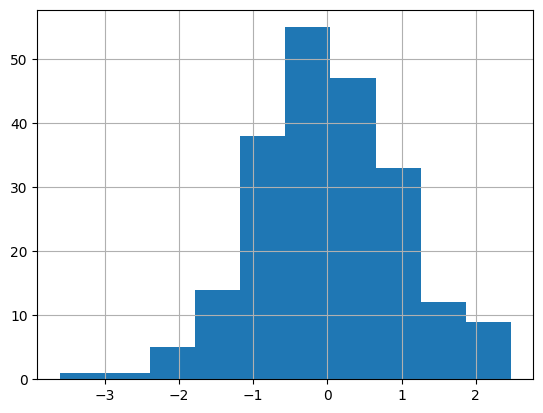

In [15]:
# gold data 
def scale(col):
    return (col - col.mean()) / col.std()

iau = yf.download("IAU", start="2005-01-01", end="2023-01-01", interval="1mo")
iau["open_ret"] = (iau["Adj Close"] - iau["Open"])/iau["Open"]
iau["open_ret"] = scale(iau["open_ret"])
iau["open_ret"].hist()

In [23]:
def rsi(ret, period=10):
    return ret.rolling(period).apply(lambda x: 100 - (100 / (1 + (x[x>=0].mean()/abs(x[x<0].mean())))))
def roc(ret, period=10):
    return ret.rolling(period).apply(lambda x: 100 * (x[-1] - x[0])/x[0])

[*********************100%%**********************]  1 of 1 completed


<Axes: >

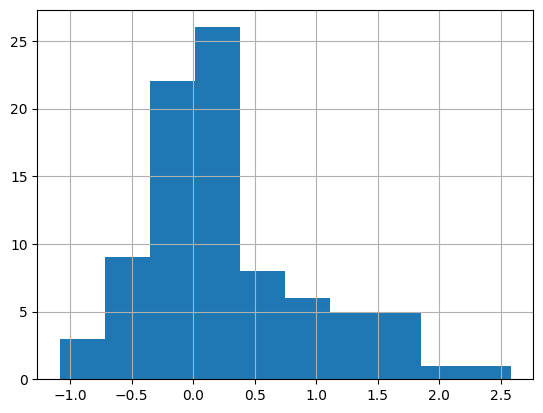

In [60]:
# sp500 data
spy = yf.download('SPY', start='2005-01-01', end='2023-01-01', interval="1mo")
spy_pt = PowerTransformer()
spy["open_ret"] = (spy["Adj Close"] - spy["Open"])/spy["Open"]
spy["open_ret"] = spy_pt.fit_transform(spy["open_ret"].to_numpy().reshape(-1,1))
spy["spy_rsi"] = spy_pt.fit_transform(rsi(spy["open_ret"]).to_numpy().reshape(-1,1))
spy = spy.dropna()
spy["open_ret"].hist()

In [24]:
# btc data
btc = yf.download("BTC-USD", start="2005-01-01", end="2023-01-01", interval="1mo")
btc["open_ret"] = (btc["Adj Close"] - btc["Open"]) / btc["Open"]
btc = btc.dropna()
pt = PowerTransformer(method='yeo-johnson')
btc["rsi"] = rsi(btc["open_ret"])
btc.dropna(inplace=True)
btc["open_ret"] = pt.fit_transform(btc["open_ret"].to_numpy().reshape(-1, 1))
btc["rsi"] = pt.fit_transform(btc["rsi"].to_numpy().reshape(-1, 1))
btc.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,open_ret,rsi
Date,,,,,,,,
2022-08-01,23336.718750,25135.589844,19600.785156,20049.763672,20049.763672,894192654543,-0.932313,-2.094507
2022-09-01,20050.498047,22673.820312,18290.314453,19431.789062,19431.789062,1123272250385,-0.372756,-2.047581
2022-10-01,19431.105469,20988.394531,18319.822266,20495.773438,20495.773438,957903424925,0.025166,-2.239233
2022-11-01,20494.898438,21446.886719,15599.046875,17168.566406,17168.566406,1224531549126,-1.047829,-2.230512
2022-12-01,17168.001953,18318.531250,16398.136719,16547.496094,16547.496094,541356716034,-0.398391,-2.158662


In [26]:
# interest rates
rf = pd.read_csv("Data/InterestRates.csv", index_col="DATE",  parse_dates=True, dtype=float).iloc[:, 0]
rf = scale(rf)
rf.head(5)

DATE
1950-01-01   -0.978808
1950-02-01   -0.978808
1950-03-01   -0.978808
1950-04-01   -0.978808
1950-05-01   -0.978808
Name: INTDSRUSM193N, dtype: float64

In [27]:
# bond yields
by = pd.read_csv("Data/BondYields.csv", index_col="DATE",  parse_dates=True, dtype=float).pct_change().dropna().iloc[:, 0]
by.head(1)
by = scale(by)

In [28]:
# cpi 
cpi = pd.read_csv("Data/CPI.csv", index_col="DATE",  parse_dates=True, dtype=float).iloc[:, 0]
cpi = scale(cpi)
cpi.head(1)

DATE
1955-02-01   -0.835674
Name: CPALTT01USM657N, dtype: float64

In [29]:
# ppi
ppi = pd.read_csv("Data/PPI.csv", index_col="DATE",  parse_dates=True, dtype=float).iloc[:, 0]
ppi = scale(ppi)
ppi.head(1)

DATE
1986-01-01   -1.371528
Name: PCUOMFGOMFG, dtype: float64

In [30]:
# liquidity from m1
m1 = pd.read_csv("Data/M1.csv", index_col="DATE",  parse_dates=True, dtype=float).pct_change().dropna().iloc[:, 0]
m1 = m1.resample("ME").apply(lambda x: (1+x).prod()-1)
m1.index = m1.index + pd.offsets.MonthBegin(1)
m1 = scale(m1)
m1.head(1)

DATE
1975-02-01   -0.685625
Name: WM1NS, dtype: float64

In [61]:
# combining everything
df = pd.DataFrame({"spy": spy["open_ret"], "iau": iau["open_ret"], "btc": btc["open_ret"],
                    "rf": rf, "by": by, "cpi": cpi, "m1": m1, "rsi": btc["rsi"], "spy_rsi": spy["spy_rsi"]}).dropna()
df.head()
df.describe()

,spy,iau,btc,rf,by,cpi,m1,rsi,spy_rsi
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.868745,0.107025,0.177957,-1.035643,-0.668761,-0.543140,0.814706,-0.238578,0.969512
std,0.710994,0.996767,0.866921,0.405329,2.085291,0.836463,4.207229,0.697109,0.309081
min,-0.304810,-1.450986,-1.549308,-1.419280,-7.621884,-2.714764,-0.778439,-1.702838,0.178910
25%,0.329376,-0.404488,-0.501607,-1.419280,-1.225759,-0.984653,-0.293464,-0.872344,0.851140
50%,0.865853,0.118746,0.140274,-1.154997,-0.318403,-0.604382,0.014810,-0.164234,1.125321
75%,1.309388,0.696852,0.825672,-0.494288,0.767153,0.175818,0.346989,0.325974,1.170697
max,2.582156,2.122359,2.006369,-0.450241,2.883881,0.749598,23.307030,1.360939,1.247440


<Axes: >

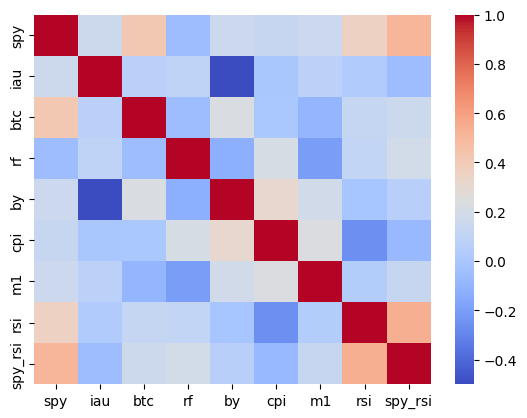

In [62]:
# corr matrix to check if high correlations between factors
import seaborn as sns
sns.heatmap(df.corr(), cmap='coolwarm')

In [63]:
from sklearn.decomposition import PCA
from statsmodels.api import OLS

pca = PCA()

X = pca.fit_transform(df.drop(columns=["btc"])[:-1])
y = df["btc"].shift(-1)[:-1]
OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    btc   R-squared (uncentered):                   0.145
Model:                            OLS   Adj. R-squared (uncentered):             -0.166
Method:                 Least Squares   F-statistic:                             0.4648
Date:                Tue, 19 Nov 2024   Prob (F-statistic):                       0.868
Time:                        14:32:05   Log-Likelihood:                         -36.568
No. Observations:                  30   AIC:                                      89.14
Df Residuals:                      22   BIC:                                      100.3
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0283      0.041      0.686      0.500      -0.057       0.114
x2             0.0453      0.083      0.547      0.590      -0.126       0.217
x3             0.0298      0.195      0.153      0.880      -0.375       0.434
x4            -0.1561      0.206     -0.758      0.456      -0.583       0.271
x5            -0.2240      0.262     -0.854      0.402      -0.768       0.320
x6             0.3351      0.331      1.012      0.322      -0.351       1.022
x7            -0.1176      0.515     -0.228      0.822      -1.187       0.951
x8             0.6345      0.861      0.737      0.469      -1.151       2.420
==============================================================================
Omnibus:                        0.491   Durbin-Watson:                   1.317
Prob(Omnibus):                  0.782   Jarque-Bera (JB):                0.371
Skew:                          -0.255   Prob(JB):                        0.831
Kurtosis:                       2.807   Cond. No.                         20.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
x = pd.Series(data=[1,2,3,4,5,6,7,8,9,10])
y = pd.Series(data=[1,2,3,4,5,6,7,8,9,10])
print(y.shift(-1)[:-1])
print(x[:-1])

0     2.0
1     3.0
2     4.0
3     5.0
4     6.0
5     7.0
6     8.0
7     9.0
8    10.0
dtype: float64
0    1
1    2
2    3
3    4
4    5
5    6
6    7
7    8
8    9
dtype: int64


In [195]:
# train test split
train = df.loc[:"2020"].copy()
test = df.loc["2020":].copy()

factors = df.columns[~(df.columns == "btc")]
print(np.array(df[factors].shape))
print(np.array(df["btc"].shape))

[82  6]
[82]


In [196]:
def display_factor_loadings(intercept, coefs, factorNames):
    '''display_factor_loadings takes an intercept, coefs, factorNames and options dict, and prints the factor loadings in a readable way
    INPUTS:
        intercept: float, intercept value
        coefs: np array, coeficients from pandas df
        factorNames: list, names of the factors
        options: dict, should contain at least one key, nameOfReg
            nameOfReg: string, name for the regression
    Outputs:
        output is printed
    '''
    loadings = np.insert(coefs, 0, intercept)
    name = 'No Name'
    out = pd.DataFrame(loadings, columns=[name])
    out = out.transpose()
    fullNames = ['Intercept'] + factorNames
    out.columns = fullNames
    print(out)

In [26]:
# applying lasso regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-12, -2, num=100)
tuned_parameters = [{'alpha': alphas}]
lasso = Lasso()

clf = GridSearchCV(lasso, tuned_parameters, cv=5, refit=True)
clf.fit(train[factors], train["btc"])
lassoBest = clf.best_estimator_

print(factors)
print(lassoBest.alpha)
print(lassoBest.coef_)

NameError: name 'train' is not defined

In [203]:
# applying ridge regression
from sklearn.linear_model import Ridge

ridge = Ridge()

clf = GridSearchCV(ridge, tuned_parameters, cv=5, refit=True)
clf.fit(train[factors], train["btc"])
ridgeBest = clf.best_estimator_

print(factors)
print(ridgeBest.alpha)
print(ridgeBest.coef_)

Index(['spy', 'iau', 'rf', 'by', 'cpi', 'm1'], dtype='object')
0.01
[ 1.22069011  0.39787717 -0.00585366 -0.02161795  0.02891144 -0.02441718]


In [209]:
def plot_pred(y_test, y_pred, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    plt.scatter(test["btc"], y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predictions vs. Actual Values')
    plt.grid(True)
    plt.show()

0.21291435353475197


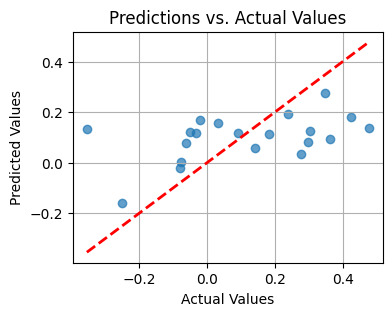

In [210]:
# testing ridge regression
print(ridgeBest.score(test[factors], test["btc"]))
plot_pred(test["btc"], ridgeBest.predict(test[factors]), figsize=(4,3))

In [212]:
# applying elastic net  
from sklearn.linear_model import ElasticNet

elasticNet = ElasticNet()

clf = GridSearchCV(elasticNet, tuned_parameters, cv=5, refit=True)
clf.fit(train[factors], train["btc"])
netBest = clf.best_estimator_

print(factors)
print(netBest.alpha)
print(netBest.coef_)

Index(['spy', 'iau', 'rf', 'by', 'cpi', 'm1'], dtype='object')
0.0019630406500402682
[ 0.54592525  0.         -0.00426448  0.          0.05323497 -0.        ]


0.13120738948208255


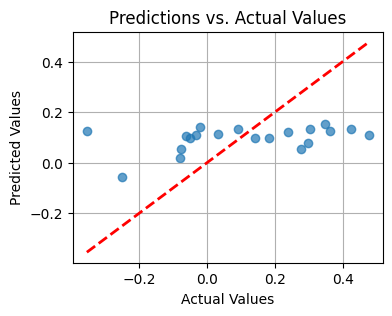

In [213]:
# testing elastic net
print(netBest.score(test[factors], test["btc"]))
plot_pred(test["btc"], netBest.predict(test[factors]), figsize=(4,3))